# Filtering results stored in tables based on IDs

In [33]:
def fetch_industries(lang='EN'):
    """
    fetches industries from the database

    Args:
    lang (str): language of the industries to fetch (EN or FR)

    Returns:
    list: list of industries in the table
    """
    
    conn = sqlite3.connect('identifiers.db')
    cursor = conn.cursor()
    cursor.execute(f"SELECT id, name FROM industries where lang = '{lang}'")
    industries = cursor.fetchall()
    conn.close()
    return industries

In [34]:
fetch_industries()

[(1, 'Plant / Machine / Metal construction'),
 (2, 'Aviation / Logistics / Transport / Traffic'),
 (3, 'Banking'),
 (4, 'Construction industry / Real estate'),
 (5, 'Clothing / Textiles'),
 (6, 'Education system'),
 (7, 'Biotechnology / Chemistry / Pharmaceutical'),
 (8, 'Retail business'),
 (9, 'Services'),
 (10, 'E-business / Internet'),
 (11, 'Electronics / Electrotechnical'),
 (12, 'Power / Water supply'),
 (13, 'Waste management / Recycling / Environmental technology'),
 (14, 'Automotive market'),
 (15, 'Precision mechanics / Optics / Watch and clock industry'),
 (16, 'Finance / Accounting'),
 (17, 'Science and research'),
 (18, 'Forestry / Agriculture'),
 (19, 'Leisure / Culture / Sports'),
 (20, 'Catering / Hotel business / Tourism'),
 (21, 'Agri-food industry'),
 (22, 'Healthcare'),
 (23, 'Small and medium-sized industries'),
 (24, 'Glass / Plastic / Paper industry'),
 (25, 'Graphic industry / Media / Publishing'),
 (26, 'Wholesale'),
 (27, 'Human resources / Personnel services

In [74]:
def filter_jobs(industry_ids: list = list(range(1,100)), employement_type_id: list = [1, 2, 3, 4, 5, 6], employement_position_id: list = [1, 2, 3]) -> list:
    """
    fetches jobs from the database filtered by industry and that are still active

    Args:
    industry_ids (list): list of ids of industries to filter by
    employement_type_id (list): list of ids of employment types to filter by
    employement_position_id (list): list of ids of employment positions to filter by

    Returns:
    list: list of jobs in the table
    """
    
    conn = sqlite3.connect('jobs.db')
    cursor = conn.cursor()
    cursor.execute(f"SELECT * FROM jobs WHERE industry IN ({','.join([str(i) for i in industry_ids])}) AND employmentTypeIds IN ({','.join([str(i) for i in employement_type_id])}) AND employmentPositionIds IN ({','.join([str(i) for i in employement_position_id])}) AND publicationEndDate > date('now')")
    jobs = cursor.fetchall()
    conn.close()
    return jobs

# Ai Agent

In [1]:
import os
from dotenv import load_dotenv
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

# For demonstration, let's assume these come from your environment
# or the same as your tutorial references:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

#from src.profile_agent.agent_classes import *
#from src.profile_agent.agent_functions import *

load_dotenv()

# I need to generate an LLm that will create a structured base user profile from the user's CV and cover letter

True

### Classes

In [2]:
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from langchain_openai import ChatOpenAI

from llm_config import LLMFactory

## Data formats

class UserProfile(BaseModel):
    """
    A class used to represent a user profile
    """
    name: str = Field(description="User's name"    )
    work_experience: str = Field(description="User's work experience")
    skills: str = Field(description="User's skills")
    education: str = Field(description="User's education")
    certifications: str = Field(description="User's certifications")
    other_info: str = Field(description="Other relevant information")

class UserProfileBuilderAssistant(BaseModel):
    """
    A class used to represent a user profile builder assistant
    """
    name: str = Field(description="Name of the analyst.")
    industry: str = Field(description="The industry of the assistant",)
    description: str = Field(description="Description of the analyst focus, concerns, and motives.",)
    @property
    def persona(self) -> str:
        return f"Name: {self.name} \n Specialty: {self.industry}\n Description: {self.description}"
    

class Perspectives(BaseModel):
    """
    A class used to represent the perspectives of the user profile builder assistants
    """
    industry_experts: List[UserProfileBuilderAssistant] = Field(
        description="List of user profile builder assistants."
    )

class SpecializedProfiles(BaseModel):
    """
    A class used to represent the specialized profiles of the user built by the profile builder assistants
    """
    specialized_profile: List[UserProfile] = Field(
        description="List of specialized user profiles."
    )

class IndustryList(BaseModel):
    """
    A class used to represent a list of industries
    """
    selected_industries: List[str] = Field(
        description="List of industries the person could work in"
    )


class JobEvaluations(BaseModel):
    """
    A class used to represent the evaluations of the fit between the user and a job
    """
    job_ids: List[str] = Field(
        description="List of job ids"
    )
    company_names: List[str] = Field(
        description="List of company names"
    )
    job_titles: List[str] = Field(
        description="List of job titles"
    )
    job_descriptions: List[str] = Field(
        description="List of job descriptions"
    )
    fit_scores: List[int] = Field(
        description="List of fit scores between the user and a job"
    )
    fit_evaluations: List[str] = Field(
        description="List of evaluations of the fit between the user and a job"
    )

## States

class ProfileState(TypedDict):
    user_docs: List[str]
    user_profile: UserProfile
    user_feedback: str

class OldProfileState(TypedDict):
    """
    A class used to represent the state of the profile generation
    """
    user_docs: List[str]
    user_profile: UserProfile
    #keyword_list: Annotated[list, operator.add]
    selected_industries: IndustryList
    job_ids: Annotated[list, operator.add]
    max_industry_experts: int
    max_num_turns: int
    results_to_retrieve: int
    industry_experts: List[UserProfileBuilderAssistant]
    user_feedback: str
    chroma_path: str
    all_jobs: List[str]
    job_evaluations: List[JobEvaluations]


class SingleProfileState(TypedDict):
    """
    State used in the subgraph that creates exactly one specialized profile
    for a single industry-expert assistant.
    """
    user_profile: UserProfile
    in_progress_profile: str # We'll fill this in
    max_num_turns: int
    industry_expert: UserProfileBuilderAssistant
    messages: List[str]  # if you want to store the conversation turn-by-turn
    keyword_list: str
    chroma_path: str
    job_ids: List

class JobEvaluationState(TypedDict):
    """
    State used in the subgraph that evaluates the fit between an individual and a job
    """
    job: List[str] # Will contain the id, company name, job title, and job description
    user_profile: UserProfile

In [12]:
import sys
print("\n".join(sys.path))


c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\python311.zip
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\DLLs
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial

c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages\win32
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages\win32\lib
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages\Pythonwin
c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\backend
c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\backend\--
c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\backend\apps
c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy


### Agent 1 : Build your profile

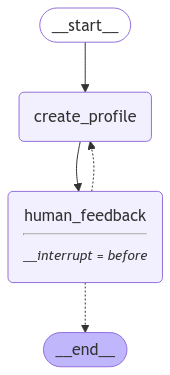

In [3]:
import sys
import os

# Get the absolute path to the root directory ('Lucy')
root_path = os.path.abspath(os.path.join(os.getcwd(), '../../../'))  # Adjust path to reach 'Lucy'
if root_path not in sys.path:
    sys.path.append(root_path)

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "backend.settings")
import django
django.setup()


from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from backend.apps.job_scraping.models import Job
from backend.settings import JOB_ADS_EMBEDDINGS_PATH
from llm_config import LLMFactory
from asgiref.sync import sync_to_async, async_to_sync

# Custom functions
from backend.apps.job_scraping.constants import fetch_industries

def create_profile(state: ProfileState) -> dict:
    """
    Creates a summary of the user's profile.

    Args:
    user_docs (List[str]): list of user documents

    Returns:
    str: user profile summary
    """

    system_message = """Your task is to create a detailed user work profile. The user has provided the following documents:
    A CV (please note the content of the CV may be in a strange order due to the format of the document. Please try to reconstruct it in a way that makes sense): 
    {cv}

    A cover letter: 
    {cover_letter}

    Take into consideration the optionally provided user feedback to improve the quality of the generated profile:

    {user_feedback}
    
    Please generate a detailed user profile based on these documents and optional feedback.
    The profile must include the following sections:
    (a) The user's name
    (b) Work experiences
    (c) Skills
    (d) Education
    (e) Certifications
    (f) Other information
    
    Be exhaustive and do not leave any important experience out.
    However, and this is crucial, do not invent anything. 
    If the provided documents and user feedback do not permit you to generate a section, leave it empty.
    I REPEAT: DO NOT INVENT ANY INFORMATION! LEAVE BLANK IF YOU CANNOT ANSWER!

    For example, do not write:
    - Sales Manager at ABC Company
    - Marketing Specialist at XYZ Company
    - Bachelors degree in Computer Science from ABC University
    
    Instead leave it blank.
    """

    system_message = system_message.format(
        cv=state['user_docs'][0],
        cover_letter=state['user_docs'][1], 
        user_feedback=state.get('user_feedback', '')
        )
        
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(UserProfile)
    
    # Update the state with the generated base_profile
    detailed_profile= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you generate the user profile please?")])

    return {"user_profile": detailed_profile}

def human_feedback(state: ProfileState):
    """ No-op node that should be interrupted on """
    print('Would you like to add something ?')
    pass


def should_continue(state: ProfileState) -> str:
    """ Return the next node to execute """
    
    # Check if human feedback is present
    human_feedback = state.get('user_feedback', None)
    if human_feedback:
        return "create_profile"
    
    # Otherwise continue
    # Store the user profile in the database
    user_profile = state.get('user_profile')
    if user_profile:
        from backend.apps.profile_agent.models import DBUserProfile
        
        profile = DBUserProfile(
            name=user_profile.name,
            work_experience=user_profile.work_experience,
            skills=user_profile.skills, 
            education=user_profile.education,
            certifications=user_profile.certifications,
            other_info=user_profile.other_info
        )
        profile.save()
        return "END"



# Build subgraph

profile_builder = StateGraph(ProfileState)
profile_builder.add_node("create_profile", create_profile)
profile_builder.add_node('human_feedback', human_feedback)

profile_builder.add_edge(START, "create_profile")
profile_builder.add_edge('create_profile', 'human_feedback')
profile_builder.add_conditional_edges('human_feedback', should_continue, ['create_profile', END])

memory = MemorySaver()
profile_graph = profile_builder.compile(checkpointer=memory, interrupt_before=['human_feedback'])

display(Image(profile_graph.get_graph().draw_mermaid_png()))

In [4]:
from backend.apps.data_processing.process_documents import process_cv, process_cover_letter
#from src.profile_agent.agent_classes import ProfileState
from backend.settings import JOB_ADS_EMBEDDINGS_PATH

file_paths = [r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CV_2024.pdf", r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CoverLetter.pdf"]
thread = {"configurable": {"thread_id": "1"}}

test_state = ProfileState(
    user_docs=[process_cv(file_paths[0]), process_cover_letter(file_paths[1])],
    user_profile=None,
    human_feedback=None,
    )

state = profile_graph.invoke(test_state, thread)

In [11]:
state = profile_graph.get_state(thread)

def print_state_snapshot(snapshot):
    """Pretty print a StateSnapshot object"""
    print("=== State Values ===")
    for key, value in snapshot.values.items():
        print(f"\n{key}:")
        if isinstance(value, (list, dict)):
            if key == "user_docs":
                print("[<CV text...>, <Cover letter text...>]")  # Simplified docs display
            else:
                print(f"{value}")
        else:
            # For Pydantic models like UserProfile
            try:
                data = value.model_dump()
                # Print each field of the UserProfile on a new line with indentation
                for field, field_value in data.items():
                    print(f"  {field}:")
                    # Format multi-line strings with proper indentation
                    formatted_value = field_value.replace('\n', '\n    ') if isinstance(field_value, str) else field_value
                    print(f"    {formatted_value}")
            except:
                print(f"{value}")
    
    print("\n=== Next Node ===")
    print(snapshot.next)
    
    print("\n=== Config ===")
    print(snapshot.config)
    
    print("\n=== Metadata ===")
    print(f"Created at: {snapshot.metadata.get('created_at')}")
    print(f"Step: {snapshot.metadata.get('step')}")
    print(f"Thread ID: {snapshot.metadata.get('thread_id')}")

# Use it like this:
print_state_snapshot(state)

=== State Values ===

user_docs:
[<CV text...>, <Cover letter text...>]

user_profile:
  name:
    Tyler R. Kleinbauer, PhD
  work_experience:
    1. ARGUSA SA – DATA SCIENCE AND ANALYTICS ENGINEERING CONSULTANT (from 2023)
       - Machine Learning and Data Science: Developed advanced machine learning models for a large international bank and created chatbots using Streamlit.
       - Automation and Data Engineering: Automated web scraping using a Dockerized bot on AWS and Snowflake.
       - Dashboards and Reporting: Created dashboards for a luxury watchmaker's IAM department and led marketing initiatives.
       - Training and Development: Conducted training courses on Tableau.
    
    2. UNIL – DATA SCIENTIST AND DOCTORAL RESEARCHER (2018 – 2022)
       - Specialized in supervised and unsupervised learning and conducted research in various machine learning techniques.
       - Analyzed leadership impact on U.S. State GDP growth and evaluated ML estimator performance.
       - Led 

In [9]:
profile_graph.update_state(thread,
                    {"user_feedback": r"from 2017 to 2018 I co-founded LeCycle, a 'circular economy' startup that recycled used coffee grounds from restaurants and cafe's in Lausanne by using it to grow edible oyster mushrooms."},
                    as_node="human_feedback"
                    )

profile_graph.invoke(None, thread)

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [10]:
update_1_state = profile_graph.get_state(thread)

print_state_snapshot(update_1_state)

=== State Values ===

user_docs:
["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Proje

C:\Users\TylerKleinbauer\AppData\Local\Temp\ipykernel_29452\299193789.py:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  print(f"{value.dict()}")


In [14]:
further_feedack = None
profile_graph.update_state(thread, {'user_feedback':further_feedack}, as_node='human_feedback')
profile_graph.invoke(None, thread)

SynchronousOnlyOperation: You cannot call this from an async context - use a thread or sync_to_async.

### Agent 2 : Find Jobs

### Functions

In [10]:
import sys
import os

# Get the absolute path to the root directory ('Lucy')
root_path = os.path.abspath(os.path.join(os.getcwd(), '../../../'))  # Adjust path to reach 'Lucy'
if root_path not in sys.path:
    sys.path.append(root_path)

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "backend.settings")
import django
django.setup()


from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from backend.apps.job_scraping.models import Job
from backend.settings import JOB_ADS_EMBEDDINGS_PATH
from llm_config import LLMFactory
from asgiref.sync import sync_to_async, async_to_sync


# Custom functions
from backend.apps.job_scraping.constants import fetch_industries

## Import classes
#from src.profile_agent.agent_classes import *


def get_list_of_possible_industries(state: ProfileState) -> dict:
    """
    Fetches a list of possible industries for the user profile

    Args:
    state (GenerateProfileState): state of the profile generation

    Returns:
    list: list of possible industries
    """
    all_industries = fetch_industries()
    
    system_message = """Your task is to generate a list of possible industries that the user could work in based on their profile. 
    The user has the following profile:
    {user_profile}

    The possible industries are:
    {all_industries}
    
    Please generate a list of the {max_industry_experts} most likely possible industries that the user could work in.
    """

    system_message = system_message.format(
        user_profile=state.get('user_profile'),
        all_industries=all_industries,
        max_industry_experts=state.get('max_industry_experts')
        )

    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(IndustryList)
    
    # Update the state with the generated base_profile
    selected_industries= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you generate a list of possible industries for the user profile please?")])

    return {"selected_industries": selected_industries}

def create_profile_builder(state: ProfileState):
    """
    Creates a set of AI assistants to help users build their work profiles.

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    dict: profile builder assistants
    """

    max_industry_experts = state['max_industry_experts']
    user_profile = state['user_profile']
    selected_industries = state['selected_industries']

    #Enforce structured output
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(Perspectives)

    profile_builder_instructions= """You are tasked with creating a set of AI assistants. The purpose of these assistants is to help users build their work profiles. 

        1. First, review the detailed user profile
        {user_profile}

        2. Then review the list of possible industries that the user could work in : {selected_industries}

        3. Based on the user profile and the list of possible industries, create one specialized industry expert for each industry in the list, that is {max_industry_experts} industry experts in total.
        """
    
    
    # System message
    system_message = profile_builder_instructions.format(user_profile=user_profile,
                                                         max_industry_experts=max_industry_experts,
                                                         selected_industries=selected_industries)
    
    # Generate question
    profile_assistant_results = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of profile builder assistants.")])

    # Write the list of assistants to state
    return {"industry_experts": profile_assistant_results.industry_experts}

def industry_expert_node(state: SingleProfileState):
    """
   Generates a specialized profile from the perspective of an industry expert.
   Asks an HR expert to review the specialized profile.

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    List: specialized profiles
    """
    # Get state
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    industry_expert = state['industry_expert']
    user_profile = state['user_profile']
    in_progress_profile = state['in_progress_profile']

    # Write system message
    in_progress_profile_instructions = """You are an industry expert. 
    Your task is to generate a specialized profile for the user based on the user's detailed profile and the possible industrie that the user could work in.
    You will work together with an HR expert to perfect the profile and make the user stand out in the job market.
    
    The purpose of this profile down the line will be to perform similarity search between this user profile and jobs descriptions. 
    Therefore, it is important that the specialized profile you create be as detailed as possible and contain as many relevant keywords as possible while staying true to the actual profile of the user.
    
    1. First, review your persona: {industry_expert.persona}.
    
    2. Second, review the user profile: {user_profile}.

    3. Third, based on the user profile and the possible industries, generate a specialized profile for the user.
    
    4. Continue to review this profile with the HR expert until it is perfect.

    When you are satisfied with the profile say: "I think we are done!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

    in_progress_profile_instructions = in_progress_profile_instructions.format(industry_expert=industry_expert, 
                                                                               user_profile=user_profile,
                                                                               in_progress_profile=in_progress_profile)

    in_progress_profile_result = llm.invoke([SystemMessage(content=in_progress_profile_instructions)]+[HumanMessage(content="Generate the specialized profile.")])

    if "messages" not in state:
        state["messages"] = []
    state["messages"].append(in_progress_profile_result)
    
    return {"in_progress_profile": [in_progress_profile_result.content]}

def hr_expert_node(state: SingleProfileState):
    """
    Helps the industry expert refine the user profile

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    List: specialized profiles
    """

    # Get state
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    industry_expert = state['industry_expert']
    user_profile = state['user_profile']
    in_progress_profile = state['in_progress_profile']


    help_industry_expert_instructions = """ You are an HR expert with a focus on recruitment and many years of experience in the field.
    Your task is to help the industry expert refine the user profile. 
    
    1. Here is the industry expert's area of focus: {industry_expert.persona}

    2. Here is the user's detailed profile: {user_profile}

    3. Here is the specialized profile they have created: {in_progress_profile}
    
    Please refine or improve the specialized profile.
    When you think it's good, say "I think we are done!"
    """

    help_industry_expert_instructions = help_industry_expert_instructions.format(industry_expert=industry_expert, 
                                                                                 user_profile=user_profile, 
                                                                                 in_progress_profile=in_progress_profile)
    
    revised_profile = llm.invoke([SystemMessage(content=help_industry_expert_instructions)]+[HumanMessage(content="Review the specialized profile.")])

    revised_profile.name = "hr"

    if "messages" not in state:
        state["messages"] = []
    state["messages"].append(revised_profile)
    
    return {"in_progress_profile": [revised_profile.content]}

def spawn_specialized_profiles(state: ProfileState):
    """
    This node spawns parallel sub-runs, each calling `single_profile_graph_compiled`.
    """
    # Get the state
    industries = state["selected_industries"].selected_industries
    industry_experts = state["industry_experts"]
    
    # zip over them:
    sends = []
    for industry, expert in zip(industries, industry_experts):
        # Create a sub-state for single_profile_graph_compiled
        single_sub_state = {
            "industry_expert": expert,
            "user_profile": state.get('user_profile'),
            "in_progress_profile": "",
            "messages": [],
            "chroma_path": state.get('chroma_path'),
        }
        # We'll spawn a parallel run
        sends.append(Send("create_specialized_profile", single_sub_state))
    return sends

def route_messages(state: SingleProfileState, name: str = "hr"):
    """
    Route between question and answer, continuing until some end condition.
    """
    # Suppose we store all messages in state["messages"]
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 1)

    # Count how many times the AI (with name=hr) has responded
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if the HR expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "format_specialized_profile"

    # Alternatively, if a certain user message indicates we’re done
    last_question = messages[-2] if len(messages) >= 2 else None
    if last_question and "I think we are done!" in last_question.content:
        return "format_specialized_profile"

    # Otherwise keep going
    return "industry_expert_node"


def format_specialized_profile(state:SingleProfileState):
    """ 
    Takes the raw in_progress_profile and formats it for job retrieval
    """

    in_progress_profile = state['in_progress_profile']
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')

    profile_formatting_instructions = """"You are an expert in recruitement. 
    You specialize in transforforming a user's profile into a list of keywords that are relevant to jobs. 

    You will be given a user profile, and your task is to create an extensive list of keywords, based on the profile, that may be present in job openings that are relevant to that user.

    Later on, these keywords will be used to perform cosine similarity between these keywords and job listings to retrieve jobs that are relevant to the user.

    Here is the user profile: {in_progress_profile}

    Create as many keywords as possible, but base them on the actual experiences of the user, as written in their profile.
    """

    profile_formatting_instructions=profile_formatting_instructions.format(in_progress_profile=in_progress_profile)

    keyword_list= llm.invoke([SystemMessage(content=profile_formatting_instructions)]+[HumanMessage(content='Please create the list of keywords')])

    return {'keyword_list': keyword_list.content}

def retrieve_id_similarity_search(state: SingleProfileState) -> ProfileState:
    
    # Get the state
    chroma_path = state.get('chroma_path')
    keyword_list = state.get('keyword_list')
    results_to_retrieve = state.get('results_to_retrieve', 5)

    # Initialize the embeddings
    embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
    
    # Initialize the Chroma vector store
    vector_store = Chroma(
    collection_name="job_ads_embeddings",
    embedding_function=embeddings,
    persist_directory=chroma_path)
    
    results = vector_store.similarity_search_with_relevance_scores(
        keyword_list,
        k=results_to_retrieve,
    )
    id_list = []
    for res in results:
        id_list.append(res[0].id)
        #print(res[0].id)
        # print(f"{res[0].metadata['job_title']} - {res[0].metadata['company_name']} \n \n")
        # print(f"{res[0].page_content} \n \n")
        # print(f"score: {res[1]} \n \n")
    
    return {'job_ids': [id_list]}


async def retrieve_jobs_from_ids(state: ProfileState) -> dict:
    """
    Asynchronously retrieves Job records based on job IDs stored in the state using Django ORM.
    
    Args:
        state (ProfileState): The state containing job_ids.
    
    Returns:
        dict: A dictionary with the key 'all_jobs' mapping to a list of tuples
              (id, company_name, template_title, template_lead) for each Job.
    """
    # Retrieve the job_ids from the state.
    ids = state.get('job_ids', [])
    # Flatten the list of lists and remove duplicates.
    ids = list(set(item for sublist in ids for item in sublist))
    
    # Use sync_to_async to wrap the ORM call and await the result.
    jobs_qs = await sync_to_async(
        lambda: list(
            Job.objects.filter(id__in=ids).values_list('id', 'company_name', 'template_title', 'template_lead')
        )
    )()
    
    return {'all_jobs': jobs_qs}

def send_to_evaluate_fit(state: ProfileState):
    """
    Prepare the data to send to evaluate_fit 

    Args:
    state (ProfileState): state of the profile generation

    Returns:
    list of Sends for evaluate_fit
    """
    # Get the state
    jobs = state.get('all_jobs', [])
    user_profile = state.get('user_profile')

    # Prepare the data to send
    sends = []
    for job in jobs:
        evaluate_fit_state = {
            'user_profile': user_profile,
            'job': job
        }
    sends.append(Send('evaluate_fit', evaluate_fit_state))
    
    return sends

def evaluate_fit(state: JobEvaluationState) -> ProfileState:
    """ 
    Evaluates the fit between the candidate an single job
    """
    # Initiate the llm
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o-mini')
    structured_llm = llm.with_structured_output(JobEvaluations)
    
    # Get the state
    job_id= state['job'][0]
    company_name= state['job'][1]
    job_title= state['job'][2]
    job_description= state['job'][3]
    user_profile= state['user_profile']
    
    # Write the system message
    system_message = """Your are a recruitement expert working for {company_name}.
    Your task is to evaluate the fit between a job you posted online and a user profile.
    
    The user profile is: {user_profile}
    
    The retrieved job information is:
    Job ID: 
    {job_id}
    Company Name: 
    {company_name}
    Job Title: 
    {job_title}
    Job Description: 
    {job_description}
    
    Please evaluate the fit between the user profile and the job along these lines:
    1) Does the candidate’s core expertise align with the key requirements of the role?
    -Does the candidate possess the required hard skills (e.g., programming languages, financial modeling, data analysis)?
    -Do they have the necessary education, certifications, or training relevant to the role?
    -How well do their past work experiences align with the technical requirements of the position?
    
    2) How has the candidate’s career trajectory prepared them for this role?
    - Has the candidate successfully performed similar tasks or projects in previous roles?
    - Can they demonstrate quantifiable achievements (e.g., increased revenue, improved efficiency)?
    - Do they have experience with the industry-specific tools, platforms, or methodologies?

    3. Does the candidate demonstrate problem-solving ability and initiative in their past roles?
    4. What motivates this candidate, and does it align with what this role offers?
    5. How does the candidate prefer to work, and does that match the company’s culture?
    6. How well does the candidate communicate complex ideas, based on their profile?
    7. Does the candidate show a growth mindset and a willingness to learn?
    8. Are there any practical constraints (salary, location, logistics) that could impact fit?
    9. Are there any red flags or inconsistencies in their career history that require clarification?
    10. Does the candidate have the potential to grow within the organization beyond this role?
    
    Please evaluate the fit between the user profile and the job and provide a score between 1 and 100.
    Additionally, please write a brief rational explaining your evaluation of the fit between the user profile and the job.
    
    """
    # Generate the output
    job_evaluation= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you evaluate the fit between the candidate and the job please?")])
    print(job_evaluation)
    return {"job_evaluations": [job_evaluation]}



### New Code

In [ ]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o")
# # llm.invoke("Hello, world!")

#https://www.jobup.ch/en/jobs/it-telecommunications/business-requirement-analyst-process-management/?jobid=3003da3a-9e0e-45ae-a042-36025458c29c

In [10]:
# # Get state and look at next node
# state = graph.get_state(thread)
# state.next

# # We now update the state as if we are the human_feedback node
# graph.update_state(thread,
#                    {"user_feedback": r"from 2017 to 2018 I co-founded LeCycle, a 'circular economy' startup that recycled used coffee grounds from restaurants and cafe's in Lausanne by using it to grow edible oyster mushrooms."},
#                    as_node="human_feedback"
#                    )
# New work experience correctly. No further human feedback needed

# further_feedback = None
# graph.update_state(thread,
#                      {"user_feedback": further_feedback},
#                      as_node="human_feedback"
#                      )

('human_feedback',)

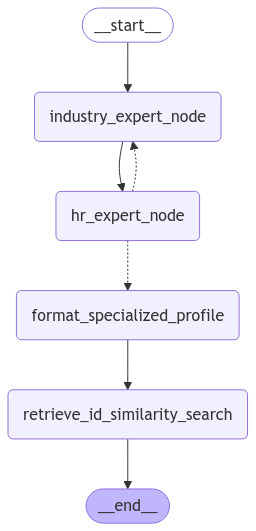

In [12]:
# Build subgraph

single_profile_builder = StateGraph(SingleProfileState)
single_profile_builder.add_node("industry_expert_node", industry_expert_node)
single_profile_builder.add_node("hr_expert_node", hr_expert_node)
single_profile_builder.add_node("format_specialized_profile", format_specialized_profile)
single_profile_builder.add_node("retrieve_id_similarity_search", retrieve_id_similarity_search)

single_profile_builder.add_edge(START, "industry_expert_node")
single_profile_builder.add_edge("industry_expert_node", "hr_expert_node")
single_profile_builder.add_conditional_edges('hr_expert_node', route_messages, ['industry_expert_node', 'format_specialized_profile'])
single_profile_builder.add_edge('format_specialized_profile', 'retrieve_id_similarity_search')
single_profile_builder.add_edge('retrieve_id_similarity_search', END)

memory = MemorySaver()
single_profile_graph = single_profile_builder.compile(checkpointer=memory).with_config(run_name="single_profile_graph")

display(Image(single_profile_graph.get_graph().draw_mermaid_png()))

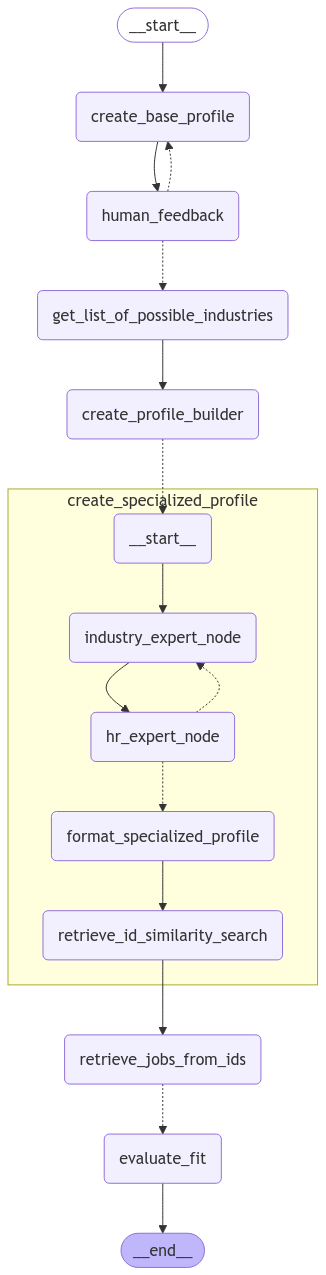

In [13]:
# Build overall graph

# Add nodes
builder = StateGraph(ProfileState)
builder.add_node("create_base_profile", create_base_profile)
builder.add_node("human_feedback", human_feedback)
builder.add_node("get_list_of_possible_industries", get_list_of_possible_industries)
builder.add_node("create_profile_builder", create_profile_builder)
builder.add_node("create_specialized_profile", single_profile_builder.compile())  # <-- rename
builder.add_node("retrieve_jobs_from_ids", retrieve_jobs_from_ids)
builder.add_node("evaluate_fit", evaluate_fit)

# Graph flow
builder.add_edge(START, "create_base_profile")
builder.add_edge("create_base_profile", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_base_profile", "get_list_of_possible_industries"])
builder.add_edge("get_list_of_possible_industries", "create_profile_builder")
builder.add_conditional_edges("create_profile_builder", spawn_specialized_profiles, ["create_specialized_profile"])
builder.add_edge("create_specialized_profile", "retrieve_jobs_from_ids")
builder.add_conditional_edges("retrieve_jobs_from_ids", send_to_evaluate_fit, ['evaluate_fit'])
builder.add_edge('evaluate_fit', END)


# Compile
memory = MemorySaver()
graph = builder.compile(#interrupt_before=["human_feedback"], 
                        checkpointer=memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
from backend.apps.data_processing.process_documents import process_cv, process_cover_letter
#from src.profile_agent.agent_classes import ProfileState
from backend.settings import JOB_ADS_EMBEDDINGS_PATH

file_paths = [r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CV_2024.pdf", r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CoverLetter.pdf"]
thread = {"configurable": {"thread_id": "1"}}

test_state = ProfileState(
    user_docs=[process_cv(file_paths[0]), process_cover_letter(file_paths[1])],
    max_industry_experts=1,
    max_num_turns=1,
    results_to_retrieve=5,
    human_feedback=None,
    chroma_path=JOB_ADS_EMBEDDINGS_PATH
    )

final_state = await graph.ainvoke(test_state, thread)

AttributeError: 'JobEvaluations' object has no attribute 'content'

In [15]:
current_state = graph.get_state(thread)

In [16]:
# from langgraph.errors import InvalidUpdateError

test = await graph.ainvoke(current_state.values, current_state.config)

job_ids=['12345'] company_names=['Tech Innovations Inc.'] job_titles=['Software Engineer'] job_descriptions=['We are looking for a Software Engineer with experience in building scalable web applications using JavaScript and Python. The ideal candidate should have a strong understanding of RESTful APIs, microservices architecture, and cloud services. Experience with Docker and Kubernetes is a plus. A degree in Computer Science or related field is required.'] fit_scores=[85] fit_evaluations=["The candidate's core expertise aligns well with the role as they possess strong programming skills in JavaScript and Python, which are essential for building scalable web applications. Their educational background in Computer Science meets the required qualifications. Past work experiences indicate familiarity with RESTful APIs and microservices, critical to the job's technical requirements. The candidate has successfully completed similar projects, showing quantifiable achievements in application p

In [15]:
from backend.settings import JOB_ADS_EMBEDDINGS_PATH

print(JOB_ADS_EMBEDDINGS_PATH)

c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\data\job_ads_embeddings


In [13]:
from langgraph.types import StateSnapshot

state_with_jobs = StateSnapshot(values={'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPresentation Skills, Leadership,\nProblem-solving\n\n\n\n\n\nTyler      R.  Kleinbauer,            PhD\n\n\nData  Scientist and Analytics Engineer\nWORK EXPERIENCE\n\nARGUSA SA – DATA SCIENCE AND ANALYTICS ENGINEERING CONSULTANT | from 2023\nMachine Learning and Data Science:\n• Used advanced yet explainable machine learning models to predict important outcomes and enhance data analytics capabilities for a large international bank.\n• Developed two chatbots using Streamlit:\n○ Secure Data Chatbot: Securely used Retrieval Augmented Generation\n(RAG) and open-source LLMs on internal data within Snowflake.\n○ Client-facing Chatbot: Proof-of-concept RAG chatbot to answer website visitor questions using OpenAI and Huggingface APIs.\nAutomation and Data Engineering:\n• Developed a Dockerized bot on AWS and Snowflake for automated web scraping, providing daily insights and sharing summaries via Slack.\n• Streamlined data processes for a large international bank using Snowpark, automating data ingestion and error monitoring, and improving data accuracy.\nDashboards and Reporting:\n• Created role mining dashboards for the IAM department of a multinational luxury watchmaker, reducing user role creation time and enhancing compliance monitoring.\n• Led marketing initiatives, including website redesign, social media management, event organization, and creating impactful reporting tools.\nTraining and Development:\n• Conducted highly-rated training courses on Tableau and Tableau Prep, boosting participants' data visualization skills.\nUNIL – DATA SCIENTIST AND DOCTORAL RESEARCHER | 2018 – 2022\nMachine Learning and Advanced Analytics:\n• Specialized in supervised and unsupervised learning, including regression, classification, clustering, and deep learning.\n• Conducted dimensionality reduction and data preprocessing for various research projects.\nQuantitative Research:\n• Analyzed the impact of leadership on U.S. State GDP growth.\n• Evaluated ML estimator performance through Monte Carlo simulations.\nProject Leadership and Academic Contributions.\n• Led multiple research projects from inception to completion.\n• Presented research at international conferences and taught courses in\nOrganizational Behavior, Statistics for Causal Analysis, and Leadership.\n\nALAYA SA – DATA SCIENCE CONSULTANT | 2020- 2021\nData Science Strategy Development:\n• Developed strategies for data collection and analysis to assess platform impacts.\n• Identified key variables for analysis, enhancing data-driven insights.\n\nEDUCATION\nPhD in Economics - University of Lausanne\n2018 – 2022 (5.5/6 GPA)\nAwards: Rising Leaders Best Paper Award, Prix de la Solidarité Confédérale\nMaster of Science in Management - University of Lausanne\n2015 – 2017 (5/6 GPA)\n• Exchange Year - Telfer School of Management, Ottawa, Canada, 2014 – 2015 (5/6 GPA)\nBachelor of Science - University of Lausanne\n2013 – 2015 (4.7/6 GPA)", "À l’attention de l’équipe Talent Acquisition.\n\n\nJe suis très enthousiaste à l'idée de postuler pour le poste d’Ingénieur.e Data et Machine Learning R&I au sein du Groupe Richemont. Rita Drissi Daoudi, de l’équipe matériaux en R&I, m’ai fait part de cette\nopportunité passionnante. Mon parcours de 7 ans en Data Science et Machine Learning, allié à mon esprit entrepreneurial et à ma capacité à lier les méthodes techniques aux objectifs commerciaux, me motive à\npostuler pour ce rôle.\n\nLa force qui m’anime est une curiosité pour les nouvelles technologies et un désir d’y trouver des applications concrètes et utiles. Par exemple, j'ai initié le développement d'un bot Dockerisé déployé sur\nAWS et Snowflake pour automatiser la collecte de données via web scraping. Ce projet, né de ma propre initiative, permet de partager automatiquement des insights quotidiens de nos partenaires avec l'équipe\nArgusa via Slack. Cette expérience démontre ma capacité à innover, à travailler de manière autonome et à piloter des projets de bout en bout.\nMon intérêt pour la technologie et l'innovation ma également poussé à développer deux chatbots, l'un sécurisé, utilisant des LLMs open source sans sortie d’informations confidentielles, utilisant la ‘retrieval\naugmented generation’ (RAG) sur des données internes, et l'autre, un proof-of-concept pour les visiteurs de notre site web, utilisant les API OpenAI et Huggingface. Ces projets illustrent ma capacité à concevoir\net à déployer des solutions techniques avancées qui répondent aux besoins de l'entreprise.\n\nBien entendu, mon rôle de ‘Data Science et Analytics Engineering Consultant’ chez Argusa m’amène également à gérer des projets clients de la conception à la mise en production, assurant une livraison\noptimale des solutions, par exemple lorsque j’ai conçu et déployé en production des outils de rôle mining pour un horloger international basé à Genève.\n\nDurant mon doctorat à l'Université de Lausanne, j'ai acquis une solide expertise en Data Science et\nMachine Learning, tout en supervisant des assistants de recherche. Cette expérience m'a permis de développer des compétences en gestion de projet, d’équipe et en leadership, essentielles pour guider\ntechniquement d'autres membres de l'équipe R&I Digital Tech ML Lab.\nMon approche analytique et orientée vers les résultats m'a conduit à mettre en place des initiatives marketing chez Argusa. J'ai mené la refonte du site web, la gestion des médias sociaux et l'organisation\nd'événements, tout en créant des tableaux de bord de reporting pour évaluer le coût et le retour sur investissement. Cette démarche démontre mon œil attentif au ROI et ma capacité à aligner les efforts\ntechniques avec les objectifs commerciaux.\n\nEn rejoignant Richemont, je souhaite apporter cette même énergie entrepreneuriale et cette capacité d'innovation pour transformer vos Maisons et manufactures. Mon expertise en développement de\nsolutions de Machine Learning et mon engagement à rester à la pointe des avancées technologiques seront des atouts pour contribuer à la stratégie R&I Digital Tech ML Lab.\n\nJe serais honoré de discuter plus en détail de la manière dont je pourrais apporter ma contribution à\nRichemont et participer à l'élaboration de solutions innovantes et impactantes. Je vous remercie de l'attention portée à ma candidature et j'espère avoir l'opportunité de vous rencontrer prochainement.\n\n\nCordialement,\n\nTyler R. Kleinbauer"], 'user_profile': UserProfile(name='Tyler R. Kleinbauer, PhD', work_experience="ARGUSA SA – DATA SCIENCE AND ANALYTICS ENGINEERING CONSULTANT | from 2023\n- Used advanced yet explainable machine learning models to predict important outcomes and enhance data analytics capabilities for a large international bank.\n- Developed two chatbots using Streamlit: a Secure Data Chatbot using RAG and open-source LLMs on internal data within Snowflake, and a client-facing Proof-of-concept RAG chatbot using OpenAI and Huggingface APIs.\n- Developed a Dockerized bot on AWS and Snowflake for automated web scraping, providing daily insights and sharing summaries via Slack.\n- Streamlined data processes for a large international bank using Snowpark, automating data ingestion and error monitoring, and improving data accuracy.\n- Created role mining dashboards for the IAM department of a multinational luxury watchmaker, reducing user role creation time and enhancing compliance monitoring.\n- Led marketing initiatives, including website redesign, social media management, event organization, and creating impactful reporting tools.\n- Conducted highly-rated training courses on Tableau and Tableau Prep, boosting participants' data visualization skills.\n\nUNIL – DATA SCIENTIST AND DOCTORAL RESEARCHER | 2018 – 2022\n- Specialized in supervised and unsupervised learning, including regression, classification, clustering, and deep learning.\n- Conducted dimensionality reduction and data preprocessing for various research projects.\n- Analyzed the impact of leadership on U.S. State GDP growth.\n- Evaluated ML estimator performance through Monte Carlo simulations.\n- Led multiple research projects from inception to completion.\n- Presented research at international conferences and taught courses in Organizational Behavior, Statistics for Causal Analysis, and Leadership.\n\nALAYA SA – DATA SCIENCE CONSULTANT | 2020-2021\n- Developed strategies for data collection and analysis to assess platform impacts.\n- Identified key variables for analysis, enhancing data-driven insights.", skills='Programming Languages: Python, SQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS, Dataiku, Tableau, Docker, Git\nPython Libraries: LangChain, OpenAI, NumPy, Scikit-learn, pandas, TensorFlow, Matplotlib, Keras, Selenium, Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native), German (beginner)\nSoft Skills: Project Management, Presentation Skills, Leadership, Problem-solving', education='PhD in Economics - University of Lausanne (2018 – 2022, 5.5/6 GPA)\nMaster of Science in Management - University of Lausanne (2015 – 2017, 5/6 GPA)\nExchange Year - Telfer School of Management, Ottawa, Canada (2014 – 2015, 5/6 GPA)\nBachelor of Science - University of Lausanne (2013 – 2015, 4.7/6 GPA)', certifications='Snowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization', other_info='Email: tyler.kleinbauer@gmail.com\nPhone: +41 78 649 97 85\nLinkedIn: https://www.linkedin.com/in/tylerkleinbauer/'), 'selected_industries': IndustryList(selected_industries=['Consultancy']), 'job_ids': [['680142fc-41e8-46b0-8793-20829384014a', 'a34c81a8-9210-4b79-a278-8201aa9ec82a', '96434580-3516-4352-80a2-d03e558c75ce', '3003da3a-9e0e-45ae-a042-36025458c29c', 'd1e0b4ba-f9d4-4b9b-ae3b-a7f2f7ff4b06'], ['680142fc-41e8-46b0-8793-20829384014a', 'a34c81a8-9210-4b79-a278-8201aa9ec82a', '3003da3a-9e0e-45ae-a042-36025458c29c', 'af3d0f5c-b30f-4981-adff-834d4e37336d', 'be31368a-c4e3-41c1-93f1-00c421f4c5e5']], 'max_industry_experts': 1, 'max_num_turns': 1, 'results_to_retrieve': 5, 'industry_experts': [UserProfileBuilderAssistant(name='Consultancy Expert', industry='Consultancy', description="The Consultancy Expert is focused on leveraging Tyler R. Kleinbauer's extensive experience in data science and analytics engineering to position him as a leading consultant in the industry. With a strong background in developing advanced machine learning models, data visualization, and process automation, this expert aims to highlight Tyler's ability to solve complex problems and drive decision-making through data-driven insights. The Consultancy Expert is concerned with showcasing Tyler's skills in programming, tools, and frameworks, as well as his proficiency in multiple languages and soft skills such as leadership and project management. The motive is to align Tyler's profile with the needs of consultancy firms looking for innovative and technically skilled consultants who can enhance client outcomes and streamline processes.")], 'chroma_path': 'c:\\Users\\TylerKleinbauer\\Dropbox\\Tyler\\Endeavors\\Scripts\\Lucy\\data\\job_ads_embeddings', 'all_jobs': [['3003da3a-9e0e-45ae-a042-36025458c29c', 'Bulgari Horlogerie SA', 'Senior Data Analyst', "In order to strengthen our Data, Business Intelligence, and AI team, we are recruiting our next :\n\nAs a key member of our Data and BI team, you will play a pivotal role in maintaining ongoing Power BI reports and projects while developing new insights that directly impact the business. Your strong analytical skills, combined with a passion for transforming business requirements into actionable insights, will support multiple departments and contribute to the company's success.You will ensure a seamless transition of projects from the previous Senior Data Analyst, while continuously evolving our data reporting landscape. You will collaborate closely with various stakeholders across departments, from High Management to Operations, ensuring the accuracy and efficiency of our data processes.Job responsibilitiesCollect, analyze, and interpret large datasets to provide business insights using Power BI.Ensure the smooth transition of current reports and projects from the existing Senior Data Analyst.Develop and maintain Power BI reports for departments including High Management, Marketing, Operations, and AFSS.Create dataflows and semantic models within Power BI to enhance reporting capabilities.Collaborate with cross-functional teams to understand business objectives and translate them into clear, actionable reporting metrics.Train and support internal teams in the effective use of Power BI and establish a Power BI users' community.Work closely with the Data Engineering team to optimize ETL pipelines and data transformation processes within the Microsoft Azure environment.Stay updated on data analysis tools, techniques, and industry trends to continuously improve the data strategy.ProfileWith a Master’s degree in computer science, data science, business intelligence, or a related field, you possess a strong analytical mindset and a proactive approach to solving complex problems. You excel in communicating technical insights to non-technical stakeholders, helping drive performance across the business.You bring a wealth of experience with a minimum of 5 years in Business Intelligence, specifically focusing on Power BI. Your expertise in data transformation processes within Power BI (Dataflows, Semantic Models, and access management) is essential to this role. Proficiency in SQL and familiarity with Data Engineering practices, particularly in ETL and pipeline management within the Microsoft Azure ecosystem, are key requirements.As a Senior Data Analyst, your role is crucial in providing the tools and insights necessary to enhance business performance while contributing to the ongoing evolution of our data-driven strategies.Fluency in both French and English is mandatory; knowledge of Italian is a plus."], ['680142fc-41e8-46b0-8793-20829384014a', 'Swiss Petroleum Card SA', 'Data Engineer & Automation Specialist', 'I.Job Responsibilities1) API Development & Data Extraction- Develop, optimize, and maintainREST API interactionsfor structured data extraction.- API request structures to collectpricing, market intelligence, and business data.- Implementweb scraping pipelinesusingPython (Requests, BeautifulSoup, Selenium)for automated dataretrieval.- Buildreal-time data synchronizationsystems that aggregate and process market-related information.2) Automation & System Optimization- Automatedata acquisition, processing, and validationusing Python-based workflows.- Developlead generation and market intelligence systemsby extracting structured data from public andprivate sources.- Implementdata pipelinesfor trackingprice movements, supply chain trends, and industry-specificdatasets.- Design alerting mechanisms thattrigger notifications on pricing fluctuations, API failures, or systemanomalies.3) Database Management & Cloud Infrastructure-Manage, query, and optimizeSQL (PostgreSQL, BigQuery, MySQL)databases for storing extracted data.- AutomateETL (Extract, Transform, Load) workflowsto maintaindata integrity and accuracy.- Deploy and manageDocker-based containerized applicationsfor scalable data processing.- UtilizeGoogle Cloud Platform (GCP) and Azurefor cloud-based data storage, VM management, anddistributed computing.4) Data Processing & Analytics- Applystatistical modelsto detect pricing trends, outliers, and market anomalies.- UsePandas and NumPyfor data manipulation, aggregation, and feature engineering.- DevelopPower BI dashboardsforreal-time data visualizationand reporting.- Implementautomated reporting systemsthat integrate with APIs and internal databases.II.Required Skills & Technologies1) Programming & Data Engineering-Python(Requests, Selenium, BeautifulSoup, Pandas, NumPy,)-SQL(BigQuery, PostgreSQL, MySQL)-C# / Scala(for backend system automation and API integration)-Docker(for deploying and managing containerized data processing applications)-ETL Pipelines(Automated Extract, Transform, Load processes)-Machine Learning & AI:TensorFlow, K-Nearest Neighbors (KNN), Sentiment Analysis, Named EntityRecognition (NER)2) Automation & Cloud Infrastructure-Web Scraping & API Integration(Requests, JSON parsing, OAuth authentication)-Google Cloud Platform (GCP) / Azure(VM management, cloud storage, API hosting)-Power BI(Automated reporting, business intelligence dashboards)-Data Workflow Automation(Task scheduling, event-driven scripting)3) Data Processing & Optimization-Automated Data Cleansing & Validation(Error detection, duplicate handling)-Statistical & Trend Analysis(Pattern recognition, outlier detection)-Anomaly Detection Systems(Real-time alerting for pricing changes, API failures)4) Languages-Russian, native-level Russian skills required,necessary for:oday-to-day interactions with Eastern European countries, post soviet countries and partnersoprocessing Russian-language market data, API documentation, and business intelligence reports-English (fluent,for technical documentation and communication)-French(basic, A2 level,for local interactions)III.Education & Experience-Previous Experience in:-API automation, cloud-based data pipelines, market intelligence systems-Price extraction, lead generation, competitor tracking-Data analytics, dashboard development, system control optimization-Financial Data Knowledge:understanding of financial markets, pricing models, and economic indicators tosupport data extraction and analysis. Ability to interpret financial datasets and integrate them into automatedworkflows.-Business & Collaboration Tools:proficiency in Microsoft Excel (advanced formulas, VBA, pivot tables), Microsoft Teams, Zoho CRM, and other collaboration platforms for workflow automation, reporting, and team coordination.IV. Additional Requirements- Experience inscaling automation workflows for high-frequency data collection.- Ability toanalyze and process unstructured financial or market data.- Strong understanding ofcloud-based data engineering, automated monitoring, and anomaly detection.- Familiarity withbusiness process automation, API management, and cloud integration.'], ['96434580-3516-4352-80a2-d03e558c75ce', None, 'Quantitative Researcher', 'MAIN DUTIES/RESPONSIBILITIES OF THE ROLE:Collaborate with Traders to optimize and improve trading strategies.Conduct in-depth research on different datasets to identify exploitable patterns.Design and implement quantitative models and trading algorithms.Develop tools for portfolio construction and risk management.WORK EXPERIENCE/BACKGROUND /TECHNICAL/BUSINESS SKILLS & KNOWLEDGE:EssentialA Master/PhD degree in Mathematics, Physics, Statistics, Computer Science or similar.Minimum of 3 years of experience in a quantitative research role, preferably within hedge funds.Proven track record of using market or alternative data to generate systematic trading signals.Strong programming skills (Python or C ) . .Ability to work collaboratively in a fast-paced, high-performance environment.Ability to deliver under pressure and take ownership.Excellent verbal and written English skills.DesirableGood mix of engineering and data science skills in the domain of time series analysis. Deep learning experience is preferred.'], ['a34c81a8-9210-4b79-a278-8201aa9ec82a', 'Michael Page Switzerland', 'Data and Information Specialist - Temporary - 100%', "We are seeking a Data and Information Specialist to lead the collection, analysis, and reporting of key data, driving insights that inform strategic decision-making and process optimisation.The role involves managing data workflows, developing automated systems, and supporting strategic projects with a focus on accuracy, collaboration, and innovation.\n\nNon-Governmental OrganizationDescriptionData Collection and Analysis - 80%Support the comprehensive collection and analysis of quantitative data across a variety of key performance indicators.Clean, process, and prepare data from various internal and external sources for analysis, ensuring its accuracy and integrity.Generate reports on emerging trends and future developments, leveraging insights from various resources.Work cross-functionally to support the integration of new tools and platforms that streamline information and data processing, ensuring timely access to critical insights.Develop, maintain, and improve automated processes for information storage and data collection, enhancing efficiency and reducing manual effort.Manage team project tracking tools and dashboards.Strategic Support - 10%Assist in the analysis and review of key programmes and initiatives.Support the logistical and administrative elements of commission activities, including meetings and observations.Collaborate on the preparation of final reports, presentations, and recommendations for internal decision-making bodies.Special Projects - 10%Support the research, development, and implementation of key strategic projects, aligning with the organisation's roadmap.ProfileQualifications and ExperienceBachelor's degree in data science, statistics, information systems, or a related field. A master's degree or equivalent professional experience is advantageous.Three to five years' experience in data analysis, preferably within a complex or large-scale environment.Fluency in English is required. Proficiency in additional languages is a plus.Advanced knowledge of data visualisation and reporting platforms such as Power BI.Familiarity with project management tools like Smartsheet and collaborative platforms in the Microsoft 365 suite.Experience working with data that is confidential and subject to data protection regulations (e.g., GDPR) and specific information security protocols.Behaviour and AttitudeHighly collaborative, with a strong commitment to team success and the ability to foster a supportive working environment.A learning mindset, curiosity, and eagerness to stay current with emerging analytics trends, including areas like AI. Openness to feedback and continuous improvement.Analytical and detail-oriented, with a passion for improving processes and driving technological advancements.Ability to translate technical concepts for non-technical audiences, confidently present challenging findings, and communicate tactfully when dealing with sensitive data or results.Creative thinker with the ability to develop new metrics and analysis methods, proactively identify data issues, and approach challenges with a solution-oriented mindset.Adaptable and capable of managing multiple priorities under pressure to meet deadlines.Committed to maintaining the highest ethical standards in all aspects of the role.The candidate must be eligible for a Swiss working permit (e.g. Swiss or EU citizenship)Job OfferUnique exposure to international projectsCompetitive package"], ['af3d0f5c-b30f-4981-adff-834d4e37336d', 'Sommet Education', 'Data & Communication Specialist', "Data & Communication SpecialistPermanent contract/ Crans-Montana, SwitzerlandLes Roches Global Hospitality Education, in the top 3 for Employer Reputation of Hospitality & Leisure Management graduates by the QS World University Ranking, is a brand of the Sommet Education Group. Founded in 1954, Les Roches is a private institution based on the Swiss model of experiential learning, offering undergraduate and graduate degrees in the fields of hospitality, tourism and event management. Les Roches prepares entrepreneurial and innovative graduates across a global network of campuses in Crans-Montana (Switzerland), Marbella (Spain) and Abu Dhabi (UAE).You share our values: Development, Distinctiveness, Joint commitment, Openness and Sense of service.We are seeking a skilled and motivatedData & Communication Specialistwho will work with cross-functional teams to analyze large datasets, develop dashboards and reports, and automate workflows. This is a unique role combining data analysis, digital support, and communication to ensure the institution's operations are data-driven and communication efforts are aligned with organizational goals. The Data & Communication Specialist will have a dual focus on two key aspects:Data & Digital Support - Supporting the maintenance of student databases and fostering a digital environment. Communication Support - Developing content and ensuring effective communication across various channels throughout the semester.Key responsibilities:Data Analysis & Digital Support:Collect, clean, and analyze large datasets to identify trends and insights.Develop and maintain dashboards and reports using tools like Power BI and Excel to support decision-making.Automate data processes and workflows with tools such as Power Automate and VBA for enhanced efficiency.Perform data quality checks to ensure accuracy, consistency, and integrity.Collaborate with teams across the organization to understand data needs and provide actionable insights.Identify opportunities for data-driven improvements and make strategic recommendations.Communication Support:Present complex data insights in clear, concise, and visually engaging formats.Develop and deliver reports, presentations, and communication materials tailored to diverse stakeholders.Translate technical findings into accessible narratives that align with organizational objectives.Facilitate effective communication between technical teams and non-technical stakeholders.Support internal and external communication strategies through data-driven content and insights.Qualifications & Experience:Bachelor's degree in Data Science, Statistics, Communications, or a related field.Proven experience in data analysis, communication, or related roles. Experience with business intelligence technologies and reporting packages is essential.Proficiency in Power BI, Power Automate, VBA, Excel, and SQL. Familiarity with programming languages such as Python or R is a plus.Strong verbal and written communication skills with the ability to present complex findings effectively. Fluency in English and French (oral and written) is required.Experience working with young adults in a multicultural environment is a plus.Advanced Excel skills, with knowledge of reporting and data visualization techniques.Familiarity with website scripts such as XML, JavaScript, and JSON is beneficial.Ability to manage multiple projects, prioritize tasks, and meet deadlines effectively.Excellent problem-solving abilities and a proactive approach to work.Strong ethical values and professional behavior with a customer-focused attitude.If you are passionate about data, communication, and student success, we invite you to apply for this exciting opportunity to join our team!Start date:January 2025"], ['be31368a-c4e3-41c1-93f1-00c421f4c5e5', 'Bechtle Suisse SA', 'Data Analyst (f/m/d)', "Be your best with BechtleAvec plus de 15 000 employés, nous sommes l'une des entreprises informatiques les plus prospères et les leaders du marché dans  notre secteur.L'association de la vente directe de produits informatiques et d'une gamme complète de prestations de services proposée par les différentes sociétés de services informatiques fait de nous un partenaire informatique fort et porteur d'avenir (« zukunftsstark ») pour les entreprises moyennes, les grands groupes et le secteur public. Nous sommes chez nous dans toute l'Europe et toujours près de chez vous.\n\nPour notre client étatique lausannois, nous recherchons un Data Analyst (f/m/d).Ta missionConcevoir et réaliser des solutions de datavisualisation modernes adaptées aux besoins des services utilisateurs.Participer activement aux séances Agiles et collaborer avec les équipes projets, architecture, intégration et infrastructure.Assurer une modélisation efficace des données et garantir leur qualité ainsi que leur documentation.Être à l'écoute des besoins des utilisateurs afin d'améliorer l'expérience client et fonctionnelle.Proposer des solutions innovantes et faire adhérer les parties prenantes aux nouvelles approches.Ton profilDiplôme en informatique d'une haute école (HES, Université, EPF) ou formation équivalente, avec au moins3 ans d'expérienceen dataviz.Expertise dans les outilsTableau,Geoserver, et les technologiesDevOps(Gitlab, VSCode, Docker).Compétences solides en transformation des données avec Python, DBT, et autres ETL.Bonne connaissance des bases de données et formats de données modernes (PostgreSQL, Parquet, Json/GeoJson).Bilingue français, anglais niveau B2 minimum,résidence en Suisse préférable.Notre propositionConditions de travail avantageuses : 6 semaines de vacances par an et un plan de prévoyance attractifModern Workplace : dernières technologies et environnement de travail moderneDiversité : des tâches intéressantes et changeantes dans un secteur tourné vers l'avenirNuméro d'emploi : PGVOD501Oksana Dumont | +41 21 632 68 11 |Bechtle Suisse SABechtle Suisse SA dispose de compétences certifiées dans les domaines stratégiques : Infrastructure IT, Virtualisation, Information Management, Managed Services, Skills Management, Data& Analytics, Printing Solutions et E-Commerce. Grâce à ces compétences et à de solides et durables partenariats avec les principaux acteurs du marché, nous proposons une gamme modulaire et parfaitement cohérente de produits et de services pour couvrir l'ensemble des besoins de nos clients. Notre proximité, notre vision globale de l'infrastructure et de la gestion de projets font de nous un acteur incontournable du marché. Nos 1000 collaborateurs motivés sont nos meilleurs atouts pour assurer rapidité, flexibilité et expertise."], ['d1e0b4ba-f9d4-4b9b-ae3b-a7f2f7ff4b06', 'Experis Switzerland', 'Data Analytics and Information Manager', "Data Analytics and Information ManagerAre you a Data Analytics and Information Manager with 6-10 years of relevant experience, in public health, monitoring and evaluation (M&E), data, or a related field? Do you have at least 3 years of experience in role of a project manager and a proven track record in project management and delivering complex technical projects, particularly in data analytics ?If so, please take a look at the following details:Experis IT Switzerland is currently on the search for a Data Analytics and Information Manager to join one of their clients, a public-private global health partnership (non-profit), based in Geneva.Your responsibilities:The Data Analytics and Information Manager will support the Measurement Evaluation and Learning team in driving two Data Analytics and Insights (DAI) workstreams in the organisation and also supporting the broader DAI mandate, including the development of their DAI strategy and operationalization plan.To deliver the required results, it's essential that you have:Advanced degree in public health, business administration, international development or similarCertification in project management (PMI, Scaled Agile, APMG, Axelos etc.) is desirable.6-10 years of relevant experience, preferably in public health, monitoring and evaluation (M&E), data, or a related field, with at least 3 years of experience in role of project manager.Proven track record in project management and delivering complex technical projects, particularly in data analytics.Experience working with financial data and/or developing grant management systems within an international organization is desirable.Experience with defining indicators, analyzing data, and developing & communicating insights to drive performance management and support decision making is desirable.Written and spoken fluency in English and preferably a good working knowledge of FrenchIf you are a dynamic and motivated Data Analytics and Information Manager currently looking for a challenging new position that applies to your skills, then we look forward to receiving your application!Don't hesitate and send us your CV today through the link in the advert. In case of any questions please contact Jane Archer on +41 22 818 8782.I'm always looking for skilled candidates don't hesitate to send me your CV for future job opportunities. Not quite what you're looking for? Don't hesitate to check out https://www.experis.ch/jobs-in-geneva to view more jobs in Geneva or connect with me on LinkedIn.Experis IT is Europe's leading recruitment agency. We have over a hundred of open vacancies and we will be more than happy to find the perfect role for you! Visit us on www.experis.ch"]]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe7e66-c073-61f3-800d-1f030baaca7d'}}, metadata={'source': 'loop', 'writes': {'retrieve_jobs_from_ids': {'all_jobs': [['3003da3a-9e0e-45ae-a042-36025458c29c', 'Bulgari Horlogerie SA', 'Senior Data Analyst', "In order to strengthen our Data, Business Intelligence, and AI team, we are recruiting our next :\n\nAs a key member of our Data and BI team, you will play a pivotal role in maintaining ongoing Power BI reports and projects while developing new insights that directly impact the business. Your strong analytical skills, combined with a passion for transforming business requirements into actionable insights, will support multiple departments and contribute to the company's success.You will ensure a seamless transition of projects from the previous Senior Data Analyst, while continuously evolving our data reporting landscape. You will collaborate closely with various stakeholders across departments, from High Management to Operations, ensuring the accuracy and efficiency of our data processes.Job responsibilitiesCollect, analyze, and interpret large datasets to provide business insights using Power BI.Ensure the smooth transition of current reports and projects from the existing Senior Data Analyst.Develop and maintain Power BI reports for departments including High Management, Marketing, Operations, and AFSS.Create dataflows and semantic models within Power BI to enhance reporting capabilities.Collaborate with cross-functional teams to understand business objectives and translate them into clear, actionable reporting metrics.Train and support internal teams in the effective use of Power BI and establish a Power BI users' community.Work closely with the Data Engineering team to optimize ETL pipelines and data transformation processes within the Microsoft Azure environment.Stay updated on data analysis tools, techniques, and industry trends to continuously improve the data strategy.ProfileWith a Master’s degree in computer science, data science, business intelligence, or a related field, you possess a strong analytical mindset and a proactive approach to solving complex problems. You excel in communicating technical insights to non-technical stakeholders, helping drive performance across the business.You bring a wealth of experience with a minimum of 5 years in Business Intelligence, specifically focusing on Power BI. Your expertise in data transformation processes within Power BI (Dataflows, Semantic Models, and access management) is essential to this role. Proficiency in SQL and familiarity with Data Engineering practices, particularly in ETL and pipeline management within the Microsoft Azure ecosystem, are key requirements.As a Senior Data Analyst, your role is crucial in providing the tools and insights necessary to enhance business performance while contributing to the ongoing evolution of our data-driven strategies.Fluency in both French and English is mandatory; knowledge of Italian is a plus."], ['680142fc-41e8-46b0-8793-20829384014a', 'Swiss Petroleum Card SA', 'Data Engineer & Automation Specialist', 'I.Job Responsibilities1) API Development & Data Extraction- Develop, optimize, and maintainREST API interactionsfor structured data extraction.- API request structures to collectpricing, market intelligence, and business data.- Implementweb scraping pipelinesusingPython (Requests, BeautifulSoup, Selenium)for automated dataretrieval.- Buildreal-time data synchronizationsystems that aggregate and process market-related information.2) Automation & System Optimization- Automatedata acquisition, processing, and validationusing Python-based workflows.- Developlead generation and market intelligence systemsby extracting structured data from public andprivate sources.- Implementdata pipelinesfor trackingprice movements, supply chain trends, and industry-specificdatasets.- Design alerting mechanisms thattrigger notifications on pricing fluctuations, API failures, or systemanomalies.3) Database Management & Cloud Infrastructure-Manage, query, and optimizeSQL (PostgreSQL, BigQuery, MySQL)databases for storing extracted data.- AutomateETL (Extract, Transform, Load) workflowsto maintaindata integrity and accuracy.- Deploy and manageDocker-based containerized applicationsfor scalable data processing.- UtilizeGoogle Cloud Platform (GCP) and Azurefor cloud-based data storage, VM management, anddistributed computing.4) Data Processing & Analytics- Applystatistical modelsto detect pricing trends, outliers, and market anomalies.- UsePandas and NumPyfor data manipulation, aggregation, and feature engineering.- DevelopPower BI dashboardsforreal-time data visualizationand reporting.- Implementautomated reporting systemsthat integrate with APIs and internal databases.II.Required Skills & Technologies1) Programming & Data Engineering-Python(Requests, Selenium, BeautifulSoup, Pandas, NumPy,)-SQL(BigQuery, PostgreSQL, MySQL)-C# / Scala(for backend system automation and API integration)-Docker(for deploying and managing containerized data processing applications)-ETL Pipelines(Automated Extract, Transform, Load processes)-Machine Learning & AI:TensorFlow, K-Nearest Neighbors (KNN), Sentiment Analysis, Named EntityRecognition (NER)2) Automation & Cloud Infrastructure-Web Scraping & API Integration(Requests, JSON parsing, OAuth authentication)-Google Cloud Platform (GCP) / Azure(VM management, cloud storage, API hosting)-Power BI(Automated reporting, business intelligence dashboards)-Data Workflow Automation(Task scheduling, event-driven scripting)3) Data Processing & Optimization-Automated Data Cleansing & Validation(Error detection, duplicate handling)-Statistical & Trend Analysis(Pattern recognition, outlier detection)-Anomaly Detection Systems(Real-time alerting for pricing changes, API failures)4) Languages-Russian, native-level Russian skills required,necessary for:oday-to-day interactions with Eastern European countries, post soviet countries and partnersoprocessing Russian-language market data, API documentation, and business intelligence reports-English (fluent,for technical documentation and communication)-French(basic, A2 level,for local interactions)III.Education & Experience-Previous Experience in:-API automation, cloud-based data pipelines, market intelligence systems-Price extraction, lead generation, competitor tracking-Data analytics, dashboard development, system control optimization-Financial Data Knowledge:understanding of financial markets, pricing models, and economic indicators tosupport data extraction and analysis. Ability to interpret financial datasets and integrate them into automatedworkflows.-Business & Collaboration Tools:proficiency in Microsoft Excel (advanced formulas, VBA, pivot tables), Microsoft Teams, Zoho CRM, and other collaboration platforms for workflow automation, reporting, and team coordination.IV. Additional Requirements- Experience inscaling automation workflows for high-frequency data collection.- Ability toanalyze and process unstructured financial or market data.- Strong understanding ofcloud-based data engineering, automated monitoring, and anomaly detection.- Familiarity withbusiness process automation, API management, and cloud integration.'], ['96434580-3516-4352-80a2-d03e558c75ce', None, 'Quantitative Researcher', 'MAIN DUTIES/RESPONSIBILITIES OF THE ROLE:Collaborate with Traders to optimize and improve trading strategies.Conduct in-depth research on different datasets to identify exploitable patterns.Design and implement quantitative models and trading algorithms.Develop tools for portfolio construction and risk management.WORK EXPERIENCE/BACKGROUND /TECHNICAL/BUSINESS SKILLS & KNOWLEDGE:EssentialA Master/PhD degree in Mathematics, Physics, Statistics, Computer Science or similar.Minimum of 3 years of experience in a quantitative research role, preferably within hedge funds.Proven track record of using market or alternative data to generate systematic trading signals.Strong programming skills (Python or C ) . .Ability to work collaboratively in a fast-paced, high-performance environment.Ability to deliver under pressure and take ownership.Excellent verbal and written English skills.DesirableGood mix of engineering and data science skills in the domain of time series analysis. Deep learning experience is preferred.'], ['a34c81a8-9210-4b79-a278-8201aa9ec82a', 'Michael Page Switzerland', 'Data and Information Specialist - Temporary - 100%', "We are seeking a Data and Information Specialist to lead the collection, analysis, and reporting of key data, driving insights that inform strategic decision-making and process optimisation.The role involves managing data workflows, developing automated systems, and supporting strategic projects with a focus on accuracy, collaboration, and innovation.\n\nNon-Governmental OrganizationDescriptionData Collection and Analysis - 80%Support the comprehensive collection and analysis of quantitative data across a variety of key performance indicators.Clean, process, and prepare data from various internal and external sources for analysis, ensuring its accuracy and integrity.Generate reports on emerging trends and future developments, leveraging insights from various resources.Work cross-functionally to support the integration of new tools and platforms that streamline information and data processing, ensuring timely access to critical insights.Develop, maintain, and improve automated processes for information storage and data collection, enhancing efficiency and reducing manual effort.Manage team project tracking tools and dashboards.Strategic Support - 10%Assist in the analysis and review of key programmes and initiatives.Support the logistical and administrative elements of commission activities, including meetings and observations.Collaborate on the preparation of final reports, presentations, and recommendations for internal decision-making bodies.Special Projects - 10%Support the research, development, and implementation of key strategic projects, aligning with the organisation's roadmap.ProfileQualifications and ExperienceBachelor's degree in data science, statistics, information systems, or a related field. A master's degree or equivalent professional experience is advantageous.Three to five years' experience in data analysis, preferably within a complex or large-scale environment.Fluency in English is required. Proficiency in additional languages is a plus.Advanced knowledge of data visualisation and reporting platforms such as Power BI.Familiarity with project management tools like Smartsheet and collaborative platforms in the Microsoft 365 suite.Experience working with data that is confidential and subject to data protection regulations (e.g., GDPR) and specific information security protocols.Behaviour and AttitudeHighly collaborative, with a strong commitment to team success and the ability to foster a supportive working environment.A learning mindset, curiosity, and eagerness to stay current with emerging analytics trends, including areas like AI. Openness to feedback and continuous improvement.Analytical and detail-oriented, with a passion for improving processes and driving technological advancements.Ability to translate technical concepts for non-technical audiences, confidently present challenging findings, and communicate tactfully when dealing with sensitive data or results.Creative thinker with the ability to develop new metrics and analysis methods, proactively identify data issues, and approach challenges with a solution-oriented mindset.Adaptable and capable of managing multiple priorities under pressure to meet deadlines.Committed to maintaining the highest ethical standards in all aspects of the role.The candidate must be eligible for a Swiss working permit (e.g. Swiss or EU citizenship)Job OfferUnique exposure to international projectsCompetitive package"], ['af3d0f5c-b30f-4981-adff-834d4e37336d', 'Sommet Education', 'Data & Communication Specialist', "Data & Communication SpecialistPermanent contract/ Crans-Montana, SwitzerlandLes Roches Global Hospitality Education, in the top 3 for Employer Reputation of Hospitality & Leisure Management graduates by the QS World University Ranking, is a brand of the Sommet Education Group. Founded in 1954, Les Roches is a private institution based on the Swiss model of experiential learning, offering undergraduate and graduate degrees in the fields of hospitality, tourism and event management. Les Roches prepares entrepreneurial and innovative graduates across a global network of campuses in Crans-Montana (Switzerland), Marbella (Spain) and Abu Dhabi (UAE).You share our values: Development, Distinctiveness, Joint commitment, Openness and Sense of service.We are seeking a skilled and motivatedData & Communication Specialistwho will work with cross-functional teams to analyze large datasets, develop dashboards and reports, and automate workflows. This is a unique role combining data analysis, digital support, and communication to ensure the institution's operations are data-driven and communication efforts are aligned with organizational goals. The Data & Communication Specialist will have a dual focus on two key aspects:Data & Digital Support - Supporting the maintenance of student databases and fostering a digital environment. Communication Support - Developing content and ensuring effective communication across various channels throughout the semester.Key responsibilities:Data Analysis & Digital Support:Collect, clean, and analyze large datasets to identify trends and insights.Develop and maintain dashboards and reports using tools like Power BI and Excel to support decision-making.Automate data processes and workflows with tools such as Power Automate and VBA for enhanced efficiency.Perform data quality checks to ensure accuracy, consistency, and integrity.Collaborate with teams across the organization to understand data needs and provide actionable insights.Identify opportunities for data-driven improvements and make strategic recommendations.Communication Support:Present complex data insights in clear, concise, and visually engaging formats.Develop and deliver reports, presentations, and communication materials tailored to diverse stakeholders.Translate technical findings into accessible narratives that align with organizational objectives.Facilitate effective communication between technical teams and non-technical stakeholders.Support internal and external communication strategies through data-driven content and insights.Qualifications & Experience:Bachelor's degree in Data Science, Statistics, Communications, or a related field.Proven experience in data analysis, communication, or related roles. Experience with business intelligence technologies and reporting packages is essential.Proficiency in Power BI, Power Automate, VBA, Excel, and SQL. Familiarity with programming languages such as Python or R is a plus.Strong verbal and written communication skills with the ability to present complex findings effectively. Fluency in English and French (oral and written) is required.Experience working with young adults in a multicultural environment is a plus.Advanced Excel skills, with knowledge of reporting and data visualization techniques.Familiarity with website scripts such as XML, JavaScript, and JSON is beneficial.Ability to manage multiple projects, prioritize tasks, and meet deadlines effectively.Excellent problem-solving abilities and a proactive approach to work.Strong ethical values and professional behavior with a customer-focused attitude.If you are passionate about data, communication, and student success, we invite you to apply for this exciting opportunity to join our team!Start date:January 2025"], ['be31368a-c4e3-41c1-93f1-00c421f4c5e5', 'Bechtle Suisse SA', 'Data Analyst (f/m/d)', "Be your best with BechtleAvec plus de 15 000 employés, nous sommes l'une des entreprises informatiques les plus prospères et les leaders du marché dans  notre secteur.L'association de la vente directe de produits informatiques et d'une gamme complète de prestations de services proposée par les différentes sociétés de services informatiques fait de nous un partenaire informatique fort et porteur d'avenir (« zukunftsstark ») pour les entreprises moyennes, les grands groupes et le secteur public. Nous sommes chez nous dans toute l'Europe et toujours près de chez vous.\n\nPour notre client étatique lausannois, nous recherchons un Data Analyst (f/m/d).Ta missionConcevoir et réaliser des solutions de datavisualisation modernes adaptées aux besoins des services utilisateurs.Participer activement aux séances Agiles et collaborer avec les équipes projets, architecture, intégration et infrastructure.Assurer une modélisation efficace des données et garantir leur qualité ainsi que leur documentation.Être à l'écoute des besoins des utilisateurs afin d'améliorer l'expérience client et fonctionnelle.Proposer des solutions innovantes et faire adhérer les parties prenantes aux nouvelles approches.Ton profilDiplôme en informatique d'une haute école (HES, Université, EPF) ou formation équivalente, avec au moins3 ans d'expérienceen dataviz.Expertise dans les outilsTableau,Geoserver, et les technologiesDevOps(Gitlab, VSCode, Docker).Compétences solides en transformation des données avec Python, DBT, et autres ETL.Bonne connaissance des bases de données et formats de données modernes (PostgreSQL, Parquet, Json/GeoJson).Bilingue français, anglais niveau B2 minimum,résidence en Suisse préférable.Notre propositionConditions de travail avantageuses : 6 semaines de vacances par an et un plan de prévoyance attractifModern Workplace : dernières technologies et environnement de travail moderneDiversité : des tâches intéressantes et changeantes dans un secteur tourné vers l'avenirNuméro d'emploi : PGVOD501Oksana Dumont | +41 21 632 68 11 |Bechtle Suisse SABechtle Suisse SA dispose de compétences certifiées dans les domaines stratégiques : Infrastructure IT, Virtualisation, Information Management, Managed Services, Skills Management, Data& Analytics, Printing Solutions et E-Commerce. Grâce à ces compétences et à de solides et durables partenariats avec les principaux acteurs du marché, nous proposons une gamme modulaire et parfaitement cohérente de produits et de services pour couvrir l'ensemble des besoins de nos clients. Notre proximité, notre vision globale de l'infrastructure et de la gestion de projets font de nous un acteur incontournable du marché. Nos 1000 collaborateurs motivés sont nos meilleurs atouts pour assurer rapidité, flexibilité et expertise."], ['d1e0b4ba-f9d4-4b9b-ae3b-a7f2f7ff4b06', 'Experis Switzerland', 'Data Analytics and Information Manager', "Data Analytics and Information ManagerAre you a Data Analytics and Information Manager with 6-10 years of relevant experience, in public health, monitoring and evaluation (M&E), data, or a related field? Do you have at least 3 years of experience in role of a project manager and a proven track record in project management and delivering complex technical projects, particularly in data analytics ?If so, please take a look at the following details:Experis IT Switzerland is currently on the search for a Data Analytics and Information Manager to join one of their clients, a public-private global health partnership (non-profit), based in Geneva.Your responsibilities:The Data Analytics and Information Manager will support the Measurement Evaluation and Learning team in driving two Data Analytics and Insights (DAI) workstreams in the organisation and also supporting the broader DAI mandate, including the development of their DAI strategy and operationalization plan.To deliver the required results, it's essential that you have:Advanced degree in public health, business administration, international development or similarCertification in project management (PMI, Scaled Agile, APMG, Axelos etc.) is desirable.6-10 years of relevant experience, preferably in public health, monitoring and evaluation (M&E), data, or a related field, with at least 3 years of experience in role of project manager.Proven track record in project management and delivering complex technical projects, particularly in data analytics.Experience working with financial data and/or developing grant management systems within an international organization is desirable.Experience with defining indicators, analyzing data, and developing & communicating insights to drive performance management and support decision making is desirable.Written and spoken fluency in English and preferably a good working knowledge of FrenchIf you are a dynamic and motivated Data Analytics and Information Manager currently looking for a challenging new position that applies to your skills, then we look forward to receiving your application!Don't hesitate and send us your CV today through the link in the advert. In case of any questions please contact Jane Archer on +41 22 818 8782.I'm always looking for skilled candidates don't hesitate to send me your CV for future job opportunities. Not quite what you're looking for? Don't hesitate to check out https://www.experis.ch/jobs-in-geneva to view more jobs in Geneva or connect with me on LinkedIn.Experis IT is Europe's leading recruitment agency. We have over a hundred of open vacancies and we will be more than happy to find the perfect role for you! Visit us on www.experis.ch"]]}}, 'thread_id': '1', 'step': 13, 'parents': {}}, created_at='2025-02-10T19:37:11.267992+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe7e66-c05a-6b48-800c-8385b2b76a15'}}, tasks=())

In [18]:
for job in state_with_jobs.values['all_jobs']:
    print(job)
    print('-'*50)

['3003da3a-9e0e-45ae-a042-36025458c29c', 'Bulgari Horlogerie SA', 'Senior Data Analyst', "In order to strengthen our Data, Business Intelligence, and AI team, we are recruiting our next :\n\nAs a key member of our Data and BI team, you will play a pivotal role in maintaining ongoing Power BI reports and projects while developing new insights that directly impact the business. Your strong analytical skills, combined with a passion for transforming business requirements into actionable insights, will support multiple departments and contribute to the company's success.You will ensure a seamless transition of projects from the previous Senior Data Analyst, while continuously evolving our data reporting landscape. You will collaborate closely with various stakeholders across departments, from High Management to Operations, ensuring the accuracy and efficiency of our data processes.Job responsibilitiesCollect, analyze, and interpret large datasets to provide business insights using Power BI

In [10]:
current_state

StateSnapshot(values={'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Pro

In [12]:
current_state.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [13]:
def print_jobs(thread):
    current_state = graph.get_state(thread)
    for item in current_state.values['all_jobs']:
        print(f'Job id: {item[0]}')
        print(f'Company Name: {item[1]}')
        print(f'Job title: {item[2]} \n')
        print('Job description: \n')
        print(f'{item[3]}')
        print('-'*50)
        print('\n')

print_jobs(thread)

Job id: 3003da3a-9e0e-45ae-a042-36025458c29c
Company Name: Bulgari Horlogerie SA
Job title: Senior Data Analyst 

Job description: 

In order to strengthen our Data, Business Intelligence, and AI team, we are recruiting our next :

As a key member of our Data and BI team, you will play a pivotal role in maintaining ongoing Power BI reports and projects while developing new insights that directly impact the business. Your strong analytical skills, combined with a passion for transforming business requirements into actionable insights, will support multiple departments and contribute to the company's success.You will ensure a seamless transition of projects from the previous Senior Data Analyst, while continuously evolving our data reporting landscape. You will collaborate closely with various stakeholders across departments, from High Management to Operations, ensuring the accuracy and efficiency of our data processes.Job responsibilitiesCollect, analyze, and interpret large datasets to

In [41]:
test.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [27]:
current_state.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [ ]:
profile = ProfileState({'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPresentation Skills, Leadership,\nProblem-solving\n\n\n\n\n\nTyler      R.  Kleinbauer,            PhD\n\n\nData  Scientist and Analytics Engineer\nWORK EXPERIENCE\n\nARGUSA SA – DATA SCIENCE AND ANALYTICS ENGINEERING CONSULTANT | from 2023\nMachine Learning and Data Science:\n• Used advanced yet explainable machine learning models to predict important outcomes and enhance data analytics capabilities for a large international bank.\n• Developed two chatbots using Streamlit:\n○ Secure Data Chatbot: Securely used Retrieval Augmented Generation\n(RAG) and open-source LLMs on internal data within Snowflake.\n○ Client-facing Chatbot: Proof-of-concept RAG chatbot to answer website visitor questions using OpenAI and Huggingface APIs.\nAutomation and Data Engineering:\n• Developed a Dockerized bot on AWS and Snowflake for automated web scraping, providing daily insights and sharing summaries via Slack.\n• Streamlined data processes for a large international bank using Snowpark, automating data ingestion and error monitoring, and improving data accuracy.\nDashboards and Reporting:\n• Created role mining dashboards for the IAM department of a multinational luxury watchmaker, reducing user role creation time and enhancing compliance monitoring.\n• Led marketing initiatives, including website redesign, social media management, event organization, and creating impactful reporting tools.\nTraining and Development:\n• Conducted highly-rated training courses on Tableau and Tableau Prep, boosting participants' data visualization skills.\nUNIL – DATA SCIENTIST AND DOCTORAL RESEARCHER | 2018 – 2022\nMachine Learning and Advanced Analytics:\n• Specialized in supervised and unsupervised learning, including regression, classification, clustering, and deep learning.\n• Conducted dimensionality reduction and data preprocessing for various research projects.\nQuantitative Research:\n• Analyzed the impact of leadership on U.S. State GDP growth.\n• Evaluated ML estimator performance through Monte Carlo simulations.\nProject Leadership and Academic Contributions.\n• Led multiple research projects from inception to completion.\n• Presented research at international conferences and taught courses in\nOrganizational Behavior, Statistics for Causal Analysis, and Leadership.\n\nALAYA SA – DATA SCIENCE CONSULTANT | 2020- 2021\nData Science Strategy Development:\n• Developed strategies for data collection and analysis to assess platform impacts.\n• Identified key variables for analysis, enhancing data-driven insights.\n\nEDUCATION\nPhD in Economics - University of Lausanne\n2018 – 2022 (5.5/6 GPA)\nAwards: Rising Leaders Best Paper Award, Prix de la Solidarité Confédérale\nMaster of Science in Management - University of Lausanne\n2015 – 2017 (5/6 GPA)\n• Exchange Year - Telfer School of Management, Ottawa, Canada, 2014 – 2015 (5/6 GPA)\nBachelor of Science - University of Lausanne\n2013 – 2015 (4.7/6 GPA)",
  "À l’attention de l’équipe Talent Acquisition.\n\n\nJe suis très enthousiaste à l'idée de postuler pour le poste d’Ingénieur.e Data et Machine Learning R&I au sein du Groupe Richemont. Rita Drissi Daoudi, de l’équipe matériaux en R&I, m’ai fait part de cette\nopportunité passionnante. Mon parcours de 7 ans en Data Science et Machine Learning, allié à mon esprit entrepreneurial et à ma capacité à lier les méthodes techniques aux objectifs commerciaux, me motive à\npostuler pour ce rôle.\n\nLa force qui m’anime est une curiosité pour les nouvelles technologies et un désir d’y trouver des applications concrètes et utiles. Par exemple, j'ai initié le développement d'un bot Dockerisé déployé sur\nAWS et Snowflake pour automatiser la collecte de données via web scraping. Ce projet, né de ma propre initiative, permet de partager automatiquement des insights quotidiens de nos partenaires avec l'équipe\nArgusa via Slack. Cette expérience démontre ma capacité à innover, à travailler de manière autonome et à piloter des projets de bout en bout.\nMon intérêt pour la technologie et l'innovation ma également poussé à développer deux chatbots, l'un sécurisé, utilisant des LLMs open source sans sortie d’informations confidentielles, utilisant la ‘retrieval\naugmented generation’ (RAG) sur des données internes, et l'autre, un proof-of-concept pour les visiteurs de notre site web, utilisant les API OpenAI et Huggingface. Ces projets illustrent ma capacité à concevoir\net à déployer des solutions techniques avancées qui répondent aux besoins de l'entreprise.\n\nBien entendu, mon rôle de ‘Data Science et Analytics Engineering Consultant’ chez Argusa m’amène également à gérer des projets clients de la conception à la mise en production, assurant une livraison\noptimale des solutions, par exemple lorsque j’ai conçu et déployé en production des outils de rôle mining pour un horloger international basé à Genève.\n\nDurant mon doctorat à l'Université de Lausanne, j'ai acquis une solide expertise en Data Science et\nMachine Learning, tout en supervisant des assistants de recherche. Cette expérience m'a permis de développer des compétences en gestion de projet, d’équipe et en leadership, essentielles pour guider\ntechniquement d'autres membres de l'équipe R&I Digital Tech ML Lab.\nMon approche analytique et orientée vers les résultats m'a conduit à mettre en place des initiatives marketing chez Argusa. J'ai mené la refonte du site web, la gestion des médias sociaux et l'organisation\nd'événements, tout en créant des tableaux de bord de reporting pour évaluer le coût et le retour sur investissement. Cette démarche démontre mon œil attentif au ROI et ma capacité à aligner les efforts\ntechniques avec les objectifs commerciaux.\n\nEn rejoignant Richemont, je souhaite apporter cette même énergie entrepreneuriale et cette capacité d'innovation pour transformer vos Maisons et manufactures. Mon expertise en développement de\nsolutions de Machine Learning et mon engagement à rester à la pointe des avancées technologiques seront des atouts pour contribuer à la stratégie R&I Digital Tech ML Lab.\n\nJe serais honoré de discuter plus en détail de la manière dont je pourrais apporter ma contribution à\nRichemont et participer à l'élaboration de solutions innovantes et impactantes. Je vous remercie de l'attention portée à ma candidature et j'espère avoir l'opportunité de vous rencontrer prochainement.\n\n\nCordialement,\n\nTyler R. Kleinbauer"],
 'user_profile': UserProfile(name='Tyler R. Kleinbauer, PhD', work_experience="1. ARGUSA SA – Data Science and Analytics Engineering Consultant (from 2023)\n   - Machine Learning and Data Science:\n     • Used advanced yet explainable machine learning models to predict important outcomes and enhance data analytics capabilities for a large international bank.\n     • Developed two chatbots using Streamlit: Secure Data Chatbot (using RAG and open-source LLMs on internal data within Snowflake) and a Client-facing Chatbot (proof-of-concept RAG chatbot using OpenAI and Huggingface APIs).\n   - Automation and Data Engineering:\n     • Developed a Dockerized bot on AWS and Snowflake for automated web scraping, providing daily insights and sharing summaries via Slack.\n     • Streamlined data processes for a large international bank using Snowpark, automating data ingestion and error monitoring, and improving data accuracy.\n   - Dashboards and Reporting:\n     • Created role mining dashboards for the IAM department of a multinational luxury watchmaker, reducing user role creation time and enhancing compliance monitoring.\n     • Led marketing initiatives, including website redesign, social media management, event organization, and creating impactful reporting tools.\n   - Training and Development:\n     • Conducted highly-rated training courses on Tableau and Tableau Prep, boosting participants' data visualization skills.\n\n2. UNIL – Data Scientist and Doctoral Researcher (2018 – 2022)\n   - Machine Learning and Advanced Analytics:\n     • Specialized in supervised and unsupervised learning, including regression, classification, clustering, and deep learning.\n     • Conducted dimensionality reduction and data preprocessing for various research projects.\n   - Quantitative Research:\n     • Analyzed the impact of leadership on U.S. State GDP growth.\n     • Evaluated ML estimator performance through Monte Carlo simulations.\n   - Project Leadership and Academic Contributions:\n     • Led multiple research projects from inception to completion.\n     • Presented research at international conferences and taught courses in Organizational Behavior, Statistics for Causal Analysis, and Leadership.\n\n3. ALAYA SA – Data Science Consultant (2020-2021)\n   - Data Science Strategy Development:\n     • Developed strategies for data collection and analysis to assess platform impacts.\n     • Identified key variables for analysis, enhancing data-driven insights.", skills='Programming Languages: Python, SQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS, Dataiku, Tableau, Docker, Git\nPython Libraries: LangChain, OpenAI, NumPy, Scikit-learn, pandas, TensorFlow, Matplotlib, Keras, Selenium, Streamlit\nFrameworks: Django, React\nLanguages: English, French (native), German (beginner)\nSoft Skills: Project Management, Presentation Skills, Leadership, Problem-solving', education='PhD in Economics - University of Lausanne (2018 – 2022, 5.5/6 GPA)\n   - Awards: Rising Leaders Best Paper Award, Prix de la Solidarité Confédérale\nMaster of Science in Management - University of Lausanne (2015 – 2017, 5/6 GPA)\n   - Exchange Year - Telfer School of Management, Ottawa, Canada (2014 – 2015, 5/6 GPA)\nBachelor of Science - University of Lausanne (2013 – 2015, 4.7/6 GPA)', certifications='Snowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization', other_info='Email: tyler.kleinbauer@gmail.com\nPhone: +41 78 649 97 85\nLinkedIn: https://www.linkedin.com/in/tylerkleinbauer/'),
 'keyword_list': [],
 'selected_industries': IndustryList(selected_industries=['Consultancy']),
 'max_industry_experts': 1,
 'industry_experts': [UserProfileBuilderAssistant(name='Dr. Tyler Kleinbauer - Consultancy Expert', industry='Consultancy', description='Dr. Tyler Kleinbauer is a seasoned expert in consultancy, specializing in data science and analytics engineering. With a robust background in machine learning, data science strategies, and project leadership, Dr. Kleinbauer leverages his extensive experience working with prestigious organizations such as ARGUSA SA and ALAYA SA. His focus is on helping consultancy firms optimize their data analytics capabilities, develop automation processes, and enhance decision-making through advanced yet explainable machine learning models. Driven by a passion for innovation, Dr. Kleinbauer aims to empower consultancy firms by improving their data-driven insights and helping them stay competitive in a rapidly evolving industry. His expertise also extends to developing impactful training programs to elevate the skill sets of consultancy professionals.')],
 'llm': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x00000231E2ED5850>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000231E300D810>, root_client=<openai.OpenAI object at 0x00000231E2ED3250>, root_async_client=<openai.AsyncOpenAI object at 0x0000023198E6BAD0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'))})

In [ ]:
import pprint
pprint.pprint(final_state)

NameError: name 'final_state' is not defined

In [20]:
all_states = [s for s in graph.get_state_history(thread)]

In [25]:
len(all_states)

6